In [22]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
import numpy as np
from scipy import stats
import pylab as plt
import torch
import swyft
from simulators import SimulatorLinePattern
import scipy.stats.distributions as dist
from unet import UNet

In [33]:
dist.uniform(0., 1.)

In [24]:
SIGMA = 0.3
RANDN_REALIZATIONS = np.random.randn(1000, 256, 256)

In [25]:
bounds = None


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2605.99it/s]


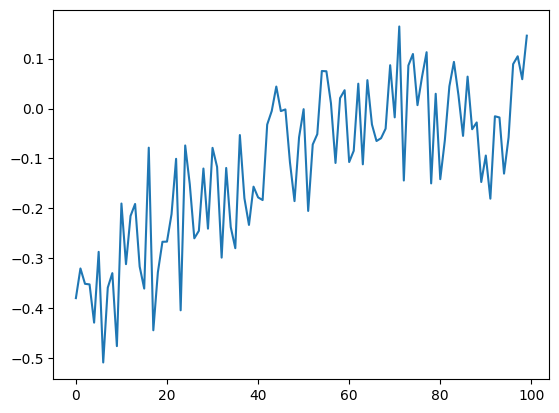

In [210]:
class SimPure(swyft.Simulator):
    def __init__(self, bounds = None, nbins = 100, sigma = 0.1):
        super().__init__()
        self.transform_samples = swyft.to_numpy32
        self.sample_z = swyft.RectBoundSampler([dist.uniform(-1, 2), dist.uniform(-1, 2), dist.uniform(-1, 2)], bounds = bounds)
        self.nbins = nbins
        self.sigma = sigma
        
    def line(self, z):
        g = np.linspace(-1, 1, self.nbins)
        return (z[0] + g*z[1] + g**2*z[2])*0.3
    
    def build(self, graph):
        z = graph.node("z", self.sample_z)
        m = graph.node('m', self.line, z)
        x = graph.node('x', lambda m: m + np.random.randn(self.nbins)*self.sigma, m)

sim = SimPure()
samples = sim.sample(1000)
x = samples[0]['x']
plt.plot(x)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 452.36it/s]


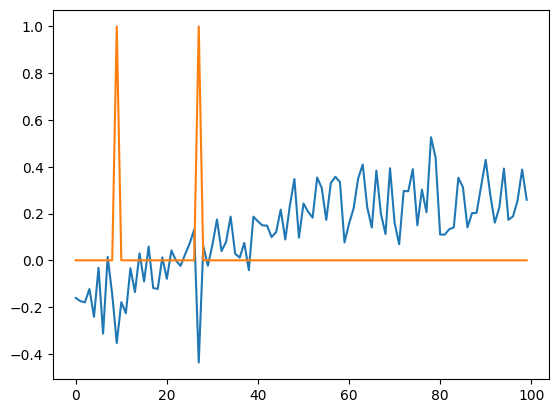

In [211]:
class SimDirty(swyft.Simulator):
    def __init__(self, sim_pure, dirt_frac = 0.1):
        super().__init__()
        self.sim_pure = sim_pure
        self.transform_samples = swyft.to_numpy32
        self.nbins = self.sim_pure.nbins
        self.sigma = self.sim_pure.sigma
        self.max_dirt_fraction = dirt_frac
    
    def dirt(self):
        p = np.random.rand()*self.max_dirt_fraction
        M = np.random.rand(self.nbins) < p
        n = M * np.random.uniform(-5*self.sigma, 5*self.sigma, self.nbins)
        return n, M
        
    def build(self, graph):
        with graph.prefix("pure/"):
            self.sim_pure.build(graph)
        pure_x = graph['pure/x']
        n, M = graph.node(['n', 'M'], self.dirt)
        graph.node("x", lambda pure_x, n: pure_x + n, pure_x, n)
        

sim2 = SimDirty(sim)
s = sim2.sample(1)[0]
plt.plot(s['x']);
plt.plot(s['M']);

In [212]:
class Network(swyft.SwyftModule):
    def __init__(self, prefix = ""):
        super().__init__()
        self.optimizer_init = swyft.AdamOptimizerInit(lr=1e-3, lrs_factor=0.3, lrs_patience=3)
        self.l1 = torch.nn.LazyLinear(3)
        self.l2 = torch.nn.LazyLinear(100)
        self.conv1 = torch.nn.Conv1d(1, 256, 1)
        self.conv2 = torch.nn.Conv1d(256, 256, 1)
        self.conv3 = torch.nn.Conv1d(256, 1, 1)
        self.a = torch.nn.ReLU()
        self.parnames = ["M[%i]"%i for i in range(100)]
        

    def forward(self, A, B):
        xA = A['x']
        fA = self.l2(self.l1(xA)) + xA  # Features as simple linear resnet
        
        zA = B['M']
        
        fA = self.conv1(fA.unsqueeze(1))
        fA = self.a(fA)
        fA = self.conv2(fA)
        fA = self.a(fA)
        fA = self.conv3(fA).squeeze(1)
        
        logratios, params = swyft.equalize_tensors(fA, zA)
        logratios = logratios*zA
        
        logratios = swyft.LogRatioSamples(logratios, params, self.parnames)
        return logratios

In [213]:
# Simulate
# Infer + get bounds
Nsims = 8192

# Simulate
samples = sim2.sample(Nsims)


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 8192/8192 [00:03<00:00, 2597.83it/s]


In [214]:
trainer = swyft.SwyftTrainer(accelerator = 'cpu', max_epochs = 100, precision = 32)
net = Network(prefix="")  # Instantiate network
dl = swyft.SwyftDataModule(samples, fractions = [0.9, 0.1, 0], batch_size = 128)
trainer.fit(net, dl)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type       | Params
-------------------------------------
0 | l1    | LazyLinear | 0     
1 | l2    | LazyLinear | 0     
2 | conv1 | Conv1d     | 512   
3 | conv2 | Conv1d     | 65.8 K
4 | conv3 | Conv1d     | 257   
5 | a     | ReLU       | 0     
-------------------------------------
66.6 K    Trainable params
0         Non-trainable params
66.6 K    Total params
0.266     Total estimated model params size (MB)


Epoch 0:  89%|███████████████████████████████████████████████████████████▊       | 58/65 [00:01<00:00, 34.08it/s, loss=-0.155, v_num=33]
Validation: 0it [00:00, ?it/s]
Epoch 1:  89%|█████████████████████████████████████████████▌     | 58/65 [00:01<00:00, 39.34it/s, loss=-0.218, v_num=33, val_loss=-.182]
Validation: 0it [00:00, ?it/s]
Epoch 2:  89%|█████████████████████████████████████████████▌     | 58/65 [00:01<00:00, 36.57it/s, loss=-0.304, v_num=33, val_loss=-.241]
Validation: 0it [00:00, ?it/s]
Epoch 3:  89%|█████████████████████████████████████████████▌     | 58/65 [00:01<00:00, 41.42it/s, loss=-0.412, v_num=33, val_loss=-.336]
Validation: 0it [00:00, ?it/s]
Epoch 4:  89%|█████████████████████████████████████████████▌     | 58/65 [00:01<00:00, 38.90it/s, loss=-0.517, v_num=33, val_loss=-.442]
Validation: 0it [00:00, ?it/s]
Epoch 5:  89%|██████████████████████████████████████████████▍     | 58/65 [00:01<00:00, 39.18it/s, loss=-0.61, v_num=33, val_loss=-.536]
Validation: 0it [00:00,